In [1]:
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.python.keras.utils.np_utils import to_categorical

## Exercise 1

#### Load data

In [2]:
(x_train, y_train), (_, _) = mnist.load_data()
x_train = (x_train - 127.5) / 127.5
y_train = to_categorical(y_train)
input_size = 28 * 28
x_train = x_train.reshape((x_train.shape[0], input_size))

#### Generator

In [3]:
optim = tf.optimizers.Adam(
    learning_rate=0.0002,
    beta_1=0.5,
)
noise_size = 32
generator = keras.Sequential(
    [
        layers.Dense(256, input_shape=(noise_size,)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(1024),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(784, activation="tanh"),
    ]
)

generator.compile(loss="mse", optimizer=optim)

#### Discriminator

In [4]:
discriminator = keras.Sequential(
    [
        layers.Dense(1024, input_shape=(784,)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid"),
    ]
)

discriminator.compile(loss="binary_crossentropy", optimizer=optim)

#### GAN

In [5]:
gan_input = layers.Input(shape=(noise_size,))
gan_output = discriminator(generator(gan_input))
gan = keras.Model(gan_input, gan_output)
gan.compile(loss="binary_crossentropy", optimizer=optim)

#### Training

In [6]:
batch_size = 128

generator_losses = []
discriminator_losses = []
dloss = 0
gloss = 0

for i in range(2500):

    for _ in range(5):
        batch_idx = sample(range(x_train.shape[0]), batch_size)
        batch_images = x_train[batch_idx, :]
        noise = np.random.normal(size=(batch_size, noise_size))
        generated = generator.predict(noise)
        dloss = discriminator.train_on_batch(
            np.vstack([batch_images, generated]),
            np.expand_dims(np.array([0.9] * batch_size + [0.1] * batch_size), 1),
        )

    noise = np.random.normal(size=(batch_size, noise_size))
    gloss = gan.train_on_batch(noise, np.expand_dims(np.array([1] * batch_size), 1))
    discriminator_losses.append(dloss)
    generator_losses.append(gloss)

    if i % 250 == 0:
        print(
            f"Step {i}, generator losses: {np.mean(generator_losses[-100:])}, discriminator losses: {np.mean(discriminator_losses[-100:])},"
        )

Step 0, generator losses: 0.9721341133117676, discriminator losses: 0.4704849123954773,
Step 250, generator losses: 0.8033317816257477, discriminator losses: 0.5725460106134415,
Step 500, generator losses: 0.8221080130338669, discriminator losses: 0.56315598487854,
Step 750, generator losses: 0.8151345330476761, discriminator losses: 0.5601272004842758,
Step 1000, generator losses: 0.8159313309192657, discriminator losses: 0.5595499545335769,
Step 1250, generator losses: 0.807854653596878, discriminator losses: 0.5644290697574615,
Step 1500, generator losses: 0.7996916097402572, discriminator losses: 0.5687394618988038,
Step 1750, generator losses: 0.7872013276815415, discriminator losses: 0.5771817183494568,
Step 2000, generator losses: 0.7831154292821885, discriminator losses: 0.578257549405098,
Step 2250, generator losses: 0.7789176762104034, discriminator losses: 0.581608214378357,


In [7]:
assert 0.5 < dloss < 0.7 < gloss < 1.0

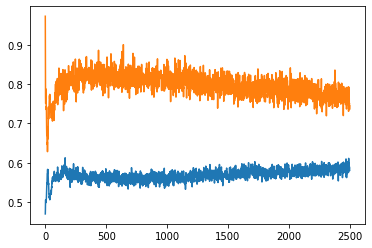

In [8]:
plt.figure()
plt.plot(discriminator_losses, label="Discriminator")
plt.plot(generator_losses, label="Generator")

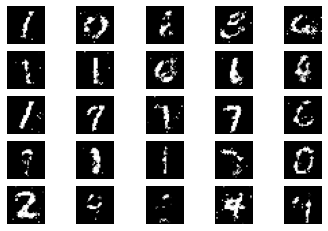

In [9]:
n_images = 25
noise = np.random.normal(size=(n_images, noise_size))
generated = generator.predict(noise)
generated = np.clip(generated, 0, 1)
for i in range(n_images):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis
    plt.axis("off")
    # plot raw pixel data
    plt.imshow(generated[i, :].reshape(28, -1), cmap="gray")
plt.show()